<a href="https://colab.research.google.com/github/SanjaySaatyaki/pytorch_4_ml_dl/blob/main/04_pytroch_custom_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn

torch.__version__

'2.6.0+cu124'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

#Get Data

Food 101's subclass

3 classes.

In [3]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path/"pizza_steak_sushi"

if image_path.is_dir():
  print("image path exists")
else:
  print(f"{image_path} does not exists")
  image_path.mkdir(parents=True,exist_ok = True)

with open(data_path/"pizza_steak_sushi.zip","wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  f.write(request.content)

data/pizza_steak_sushi does not exists


In [4]:
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip","r") as zip_ref:
  zip_ref.extractall(image_path)

## Data preparation and Data Exploration

In [5]:
import os
def walk_through_dir(dir_path):
  for dir_path, dir_names, file_names in os.walk(dir_path):
    print(f"There are {len(dir_names)} directories and {len(file_names)} images in {dir_path}")

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi


In [7]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [8]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## Visualizing a image

In [9]:
import random
from PIL import Image

random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))

In [10]:
image_path_list[:5]

[PosixPath('data/pizza_steak_sushi/test/pizza/2508636.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/309892.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/540882.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/195160.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/3475871.jpg')]

data/pizza_steak_sushi/test/sushi/479711.jpg
sushi
Random image path: data/pizza_steak_sushi/test/sushi/479711.jpg
Image class: sushi
Image height: 512
Image width: 512


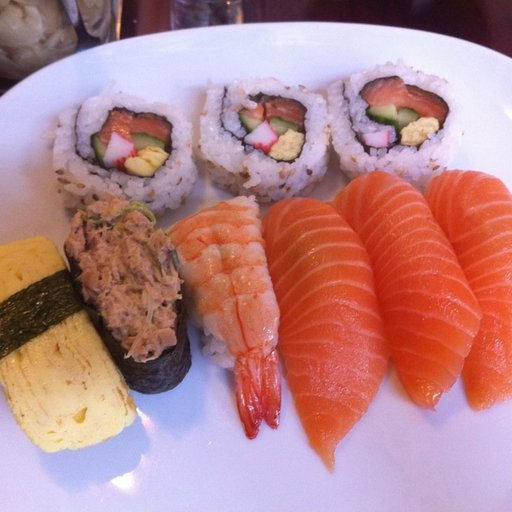

In [11]:
random_image_path = random.choice(image_path_list)
print(random_image_path)

image_class = random_image_path.parent.stem
print(image_class)

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

Text(0.5, 1.0, 'Image class: sushi| image shape:(512, 512, 3)')

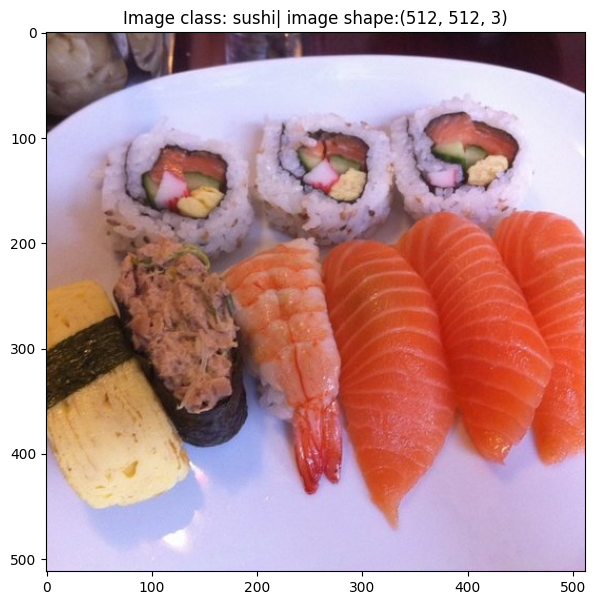

In [12]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class}| image shape:{img_as_array.shape}")

In [13]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [14]:
data_transform = transforms.Compose([
    #Resize our image to 64x64
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [15]:
data_transform(img).dtype

torch.float32

In [16]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path)as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}",fontsize=16)


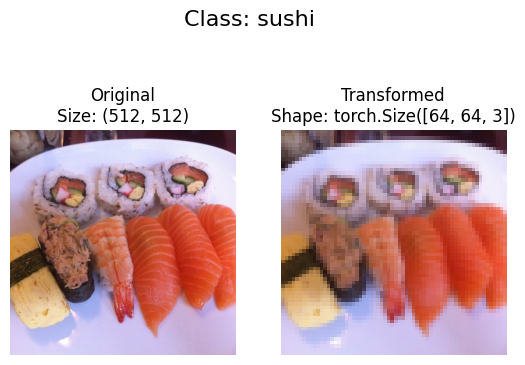

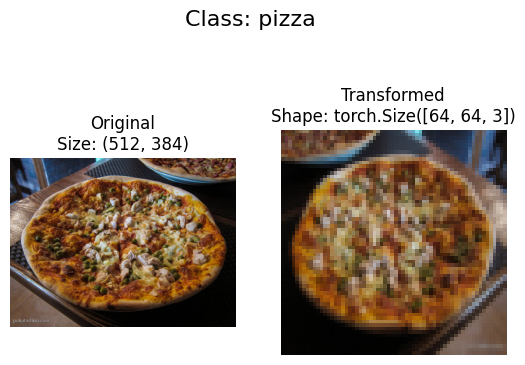

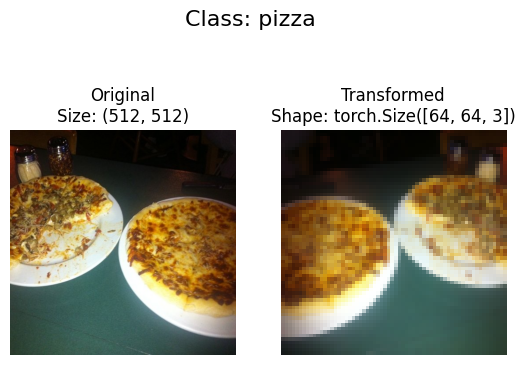

In [17]:
plot_transformed_images(image_paths=image_path_list,transform=data_transform,n=3,seed=42)

In [18]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

In [19]:
train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [20]:
class_names = train_data.classes

In [21]:
def display_random_images(dataset, classes, n, display_shape, seed):
  if n>10:
    n=10
    display_shape = False
    print("For Display purpose n shouldnt be larger than 10")
  if seed:
    random.seed(seed)

  random_samples_idx = random.sample(range(len(dataset)),k=n)

  plt.figure(figsize=(16,8))

  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    #adjust tensor dimension for ploting
    targ_image_adjust = targ_image.permute(1,2,0)

    plt.subplot(1,n,i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title+ f"\nshape:{targ_image_adjust.shape}"
    plt.title(title)


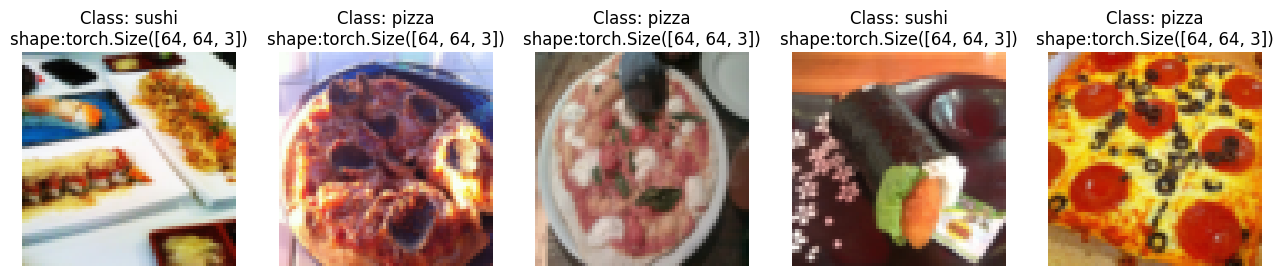

In [22]:
display_random_images(train_data,class_names,5,True,42)

In [23]:
from torchvision import transforms
train_transform = transforms.Compose([transforms.Resize(size=(244,244)),
                                     transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                      transforms.ToTensor()])

In [24]:
image_path

PosixPath('data/pizza_steak_sushi')

In [25]:
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:5]

[PosixPath('data/pizza_steak_sushi/test/pizza/2508636.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/309892.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/540882.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/195160.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/3475871.jpg')]

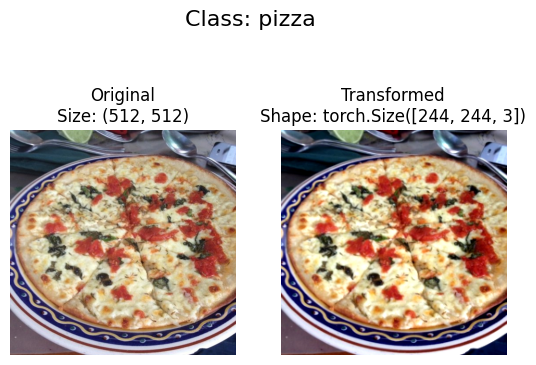

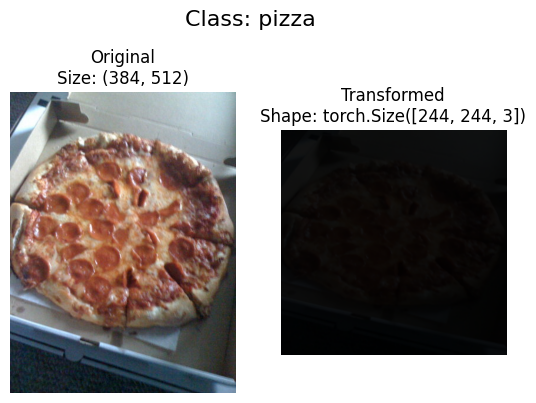

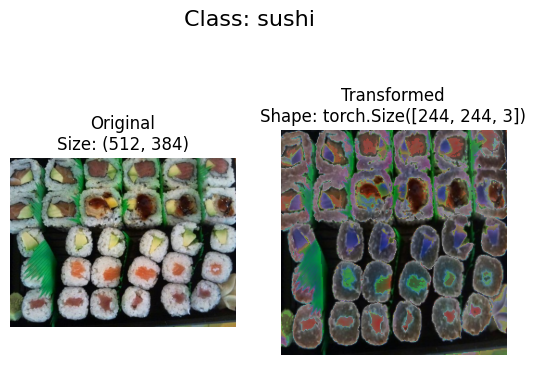

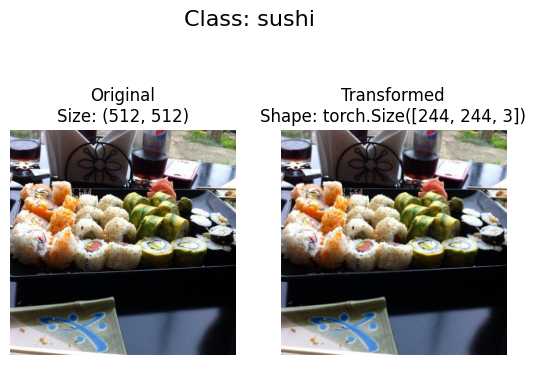

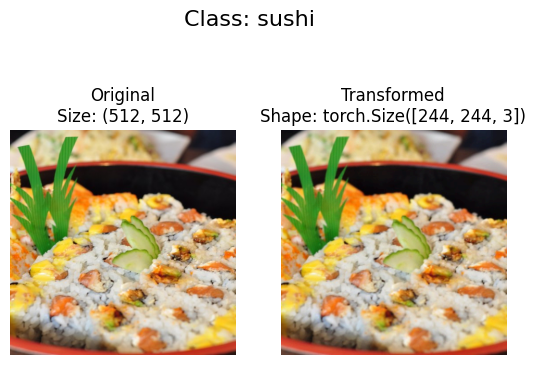

In [26]:
plot_transformed_images(image_paths=image_path_list, transform=train_transform, n=5, seed=None)

# Model 0 : Tiny VVG Architecture

In [27]:
simple_transform = transforms.Compose([transforms.Resize(size=(64,64)),
                                      transforms.ToTensor()])

In [28]:
#load and transform
from torchvision import datasets

train_data_simple = datasets.ImageFolder(root=train_dir,transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,transform=simple_transform)

In [29]:
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()


train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=True,
                                    num_workers=NUM_WORKERS)

In [49]:
class tiny_vvg_model(nn.Module):
  def __init__(self, input_shape, hidden_units, out_shape) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=out_shape)
    )

  def forward(self,x):
    x=self.conv_block_1(x)
    # print(x.shape)
    x=self.conv_block_2(x)
    # print(x.shape)
    x= self.classifier(x)
    return x
    # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # Operator fusion


In [50]:
torch.manual_seed(42)
model_0 = tiny_vvg_model(input_shape=3, hidden_units=10, out_shape=len(class_names)).to(device)
model_0

tiny_vvg_model(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [32]:
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [33]:
model_0.eval()
with torch.inference_mode():
  model_0(image_batch)

torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])


In [34]:
pip install torchinfo

In [35]:
from torchinfo import summary
summary(model_0, input_size=[1,3,64,64])

torch.Size([1, 10, 30, 30])
torch.Size([1, 10, 13, 13])


Layer (type:depth-idx)                   Output Shape              Param #
tiny_vvg_model                           [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

In [47]:
def train_step(model, data_loader, optimizer, loss_fn, device):

  model.train()

  train_loss, train_acc =0,0

  for batch, (X,y) in enumerate(data_loader):
    X,y= X.to(device), y.to(device)

    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)

    train_acc += (y_pred_class == y).sum().item()/len(y_pred)
  train_loss = train_loss / len(data_loader)
  train_acc = train_acc / len(data_loader)

  return train_loss, train_acc



In [37]:
def test_step(model, data_loader, loss_fn, device):
  model.eval()
  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    for batch, (X,y) in enumerate(data_loader):
      X,y = X.to(device), y.to(device)
      y_pred_logits = model(X)
      loss = loss_fn(y_pred_logits,y)
      test_loss +=loss.item()

      pred_labels = y_pred_logits.argmax(dim=1)
      test_acc += ((pred_labels==y).sum().item()/len(pred_labels))
    test_loss = test_loss/len(data_loader)
    test_acc = test_acc / len(data_loader)

  return test_loss, test_acc


In [38]:
pip install tqdm

In [41]:
from tqdm.auto import tqdm

def train_function(model, epochs, device, train_data_loader, test_data_loader, optimizer, loss_fn):
  results = {
      "train_loss":[],
      "train_acc":[],
      "test_loss":[],
      "test_acc":[]
      }
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model, train_data_loader,optimizer,loss_fn,device)
    test_loss, test_acc = test_step(model,test_data_loader,loss_fn, device)
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

    print(f"Epoch:{epoch}|TrainLoss:{train_loss}|TrainAcc:{train_acc}|TestLoss:{test_loss}|TestAcc:{test_acc}")
  return results

In [57]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.0001)

In [58]:
from timeit import default_timer as timer
start_time = timer()

model_0_results = train_function(model_0, 5,device, train_dataloader_simple,test_dataloader_simple, optimizer, loss_fn)

end_time = timer()
total_time = end_time-start_time
print(f"Total time:{total_time:.3f}sec")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:0|TrainLoss:1.095661535859108|TrainAcc:0.28125|TestLoss:1.0928144852320354|TestAcc:0.44223484848484845
Epoch:1|TrainLoss:1.090072438120842|TrainAcc:0.43359375|TestLoss:1.0970109303792317|TestAcc:0.300189393939394
Epoch:2|TrainLoss:1.0956965386867523|TrainAcc:0.3046875|TestLoss:1.0959001382191975|TestAcc:0.33996212121212127
Epoch:3|TrainLoss:1.086082100868225|TrainAcc:0.42578125|TestLoss:1.0968773365020752|TestAcc:0.300189393939394
Epoch:4|TrainLoss:1.0986727327108383|TrainAcc:0.3046875|TestLoss:1.0941787163416545|TestAcc:0.300189393939394
Total time:9.247sec


# Plot Loss Curves

In [55]:
def plot_loss_curves(results):
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  acc = results["train_acc"]
  test_acc = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15,7))
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs, acc, label="train_acc")
  plt.plot(epochs, test_acc, label="test_acc")
  plt.title("Acc")
  plt.xlabel("Epochs")
  plt.legend()



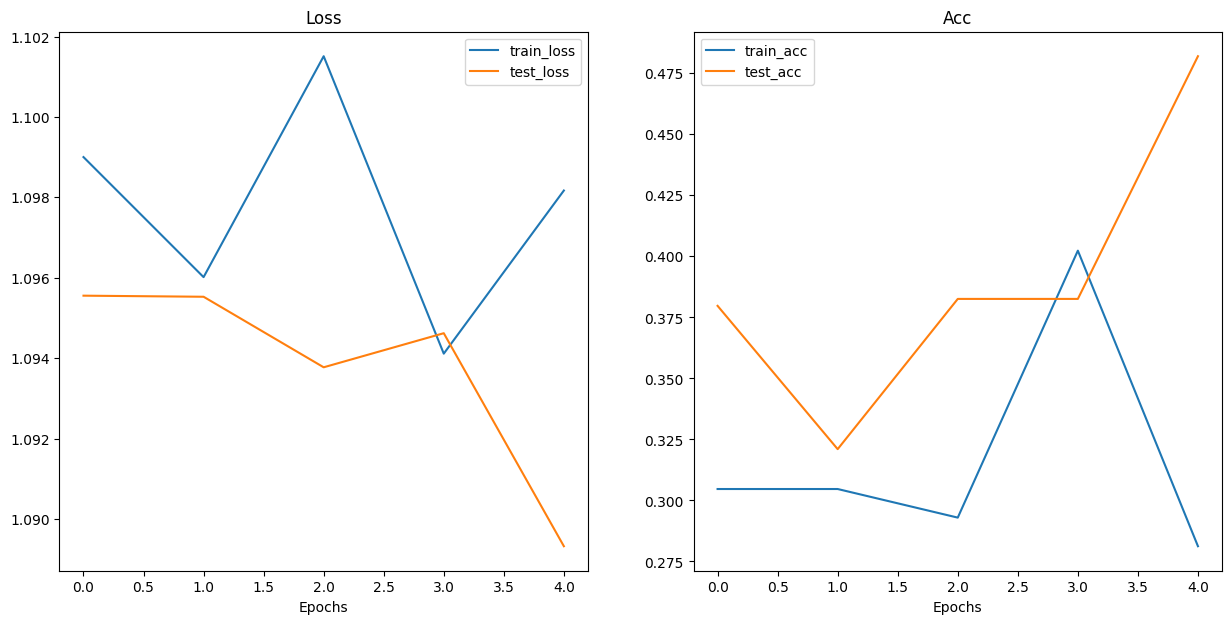

In [56]:
plot_loss_curves(model_0_results)